In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline

In [2]:
#volume_bbls
!ls

data                 edatools             sayonti_mondal.ipynb


In [3]:
import pandas as pd
import numpy as np

dfeatures=pd.read_csv("./data/features.csv")
reference = pd.read_csv("./data/fc_reference.csv")


In [4]:
dfeatures['datetime_ct'] = pd.to_datetime(dfeatures['datetime_ct'])
reference['datetime_ct'] = pd.to_datetime(reference['datetime_ct'])
dfeatures['pipe_id'] = dfeatures['pipe_id'].astype(str)
reference['pipe_id'] = reference['pipe_id'].astype(str)

In [5]:
print(dfeatures.shape);
print(reference.shape);


(4581, 13)
(1816, 3)


In [6]:
dfeatures.head()

,id,pipe_id,datetime_ct,max_bin,max_adc,count_power_cycles,max_bin_amp,all_bin_amp,temp_c,amp_peak_steepness,minutes_since_previous,percent_above_threshold,percent_edge_excluded
0,163216,56,2018-07-11 06:06:18,99.1,1764,5,4,1,52,4.0,35.2,100,0
1,163167,56,2018-07-11 05:31:08,99.1,1764,5,4,1,53,4.0,35.1,100,0
2,163102,56,2018-07-11 04:56:00,99.1,1773,5,4,1,52,4.0,35.0,100,0
3,163041,56,2018-07-11 04:21:00,99.1,1773,6,4,1,54,4.0,36.2,100,0
4,162970,56,2018-07-11 03:44:51,99.1,1773,5,4,1,54,4.0,35.1,100,0


In [7]:
reference.head()

,datetime_ct,pipe_id,volume_bbls
0,2018-07-01 09:00:00,117,1111.43
1,2018-07-01 10:00:00,117,1082.07
2,2018-07-01 11:00:00,117,1077.69
3,2018-07-01 12:00:00,117,1068.04
4,2018-07-01 13:00:00,117,1057.74


In [8]:
dfeatures['Date'], dfeatures['hour'] = dfeatures['datetime_ct'].dt.normalize(), dfeatures['datetime_ct'].dt.hour
reference['Date'], reference['hour'] = reference['datetime_ct'].dt.normalize(), reference['datetime_ct'].dt.hour
#reference= reference.sort_values(by=['pipe_id','Date'])
result = pd.merge(dfeatures,reference,on=['pipe_id','Date', 'hour'],how='inner')

In [9]:
dfeatures_cleaned = dfeatures.groupby(['pipe_id','Date','hour']).mean().reset_index()

In [10]:
data = pd.merge(dfeatures_cleaned,reference,on=['pipe_id','Date', 'hour'],how='inner')

In [11]:
data.drop(['Date', 'hour'],axis=1, inplace=True)

In [12]:
data['id'] = data['id'].astype('int')
data = data.set_index('id').reset_index()

In [13]:
""" Pivot to plot individual TS 
pv_data = data.pivot(columns="pipe_id", index="datetime_ct", values="volume_bbls").reset_index()
all_pid = data['pipe_id'].unique()
pv_data.columns = pv_data.columns.astype(str)
#pv_data.set_index("datetime_ct", inplace=True)
pv_data.index = pd.to_datetime(pv_data.index)
sns.set(rc={'figure.figsize':(15,8)})
sns.tsplot(pv_data['68'], time=pv_data.index, estimator=np.nanmax, color="green", ci=[95])
"""

' Pivot to plot individual TS \npv_data = data.pivot(columns="pipe_id", index="datetime_ct", values="volume_bbls").reset_index()\nall_pid = data[\'pipe_id\'].unique()\npv_data.columns = pv_data.columns.astype(str)\n#pv_data.set_index("datetime_ct", inplace=True)\npv_data.index = pd.to_datetime(pv_data.index)\nsns.set(rc={\'figure.figsize\':(15,8)})\nsns.tsplot(pv_data[\'68\'], time=pv_data.index, estimator=np.nanmax, color="green", ci=[95])\n'

In [14]:
data["pipe_id"] = data['pipe_id'].astype('int')
data['datetime_ct'] = pd.to_datetime(data['datetime_ct'])

In [15]:
train_cols = ['pipe_id', 'max_bin', 'max_adc', 'count_power_cycles',
       'max_bin_amp', 'all_bin_amp', 'temp_c', 'amp_peak_steepness',
       'minutes_since_previous', 'percent_above_threshold',
       'percent_edge_excluded']
y = 'volume_bbls' 

all_ids = data['pipe_id'].unique()

In [16]:
from os import path
import warnings

if not path.exists('./edatools'):
    !git clone https://github.com/rpwr021/edatools.git

from edatools.src.dstools.dstools import DStools as dst
warnings.filterwarnings("ignore")
ds = dst()

In [17]:
features = ds.process_dtypes(data, tapply = False, thr=30)

In [18]:
features

defaultdict(list,
            {'catfeatures': ['pipe_id',
              'count_power_cycles',
              'percent_edge_excluded'],
             'encode': ['datetime_ct'],
             'numfeatures': ['max_bin',
              'max_adc',
              'max_bin_amp',
              'all_bin_amp',
              'temp_c',
              'amp_peak_steepness',
              'minutes_since_previous',
              'percent_above_threshold',
              'volume_bbls'],
             'skip': ['id']})

In [19]:
from sklearn.preprocessing import StandardScaler

trans_cols = ['max_bin', 'max_adc', 'count_power_cycles',
       'max_bin_amp', 'all_bin_amp', 'temp_c', 'amp_peak_steepness',
       'minutes_since_previous', 'percent_above_threshold',
       'percent_edge_excluded']

ss = StandardScaler()
ss.fit(data[trans_cols])

t_data = pd.DataFrame(ss.transform(data[trans_cols]), columns=trans_cols)
t_data["pipe_id"] = data["pipe_id"]

In [20]:
test_data = t_data[data['volume_bbls'] < 0.0001]
train_data = t_data[data['volume_bbls'] > 0.0001]
train_data['volume_bbls'] = data[data['volume_bbls'] > 0.0001]['volume_bbls']

In [21]:
print(train_data.pipe_id.unique(), test_data.pipe_id.unique())

[111 117 125 130  56  61  68] [111 117 125 130  56  61  68]


In [22]:
train_cols

['pipe_id',
 'max_bin',
 'max_adc',
 'count_power_cycles',
 'max_bin_amp',
 'all_bin_amp',
 'temp_c',
 'amp_peak_steepness',
 'minutes_since_previous',
 'percent_above_threshold',
 'percent_edge_excluded']

In [23]:
#additional imports for the models
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as mt
from sklearn.model_selection import cross_val_score
from sklearn import metrics
pd.set_option('display.max_columns', 500)
%matplotlib inline


X_train, X_test, y_train,y_test  = train_test_split(train_data[train_cols], train_data[y],test_size=0.2,stratify=train_data['pipe_id'], random_state=111)

In [24]:
print(X_test.shape);


(235, 11)


In [25]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

model = linear_model.RidgeCV(alphas=[0.1, 1.0, 3.0, 4.0])
model.fit(X_train, y_train)

Y_pred=model.predict(X_test)
print("RMSE", np.sqrt(mean_squared_error(y_test,Y_pred)))

RMSE 667.332748463826


In [26]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.2, min_impurity_split=True,
           min_samples_leaf=3, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1, random_state=2111, verbose=0, warm_start=False)
rf.fit(X_train, y_train)

Y_pred=rf.predict(X_test)
print("RMSE", np.sqrt(mean_squared_error(y_test,Y_pred)))

RMSE 531.0492133798606


In [27]:
rf.fit(train_data[train_cols], train_data[y])
test_data["volume_bbls"] = rf.predict(test_data[train_cols])

In [28]:
for idx in train_data["pipe_id"].unique():
    print("\n processing pipe_id", idx)
    X_train, X_test, y_train,y_test  = train_test_split(train_data[train_data['pipe_id'] == idx][train_cols],\
                                                        train_data[train_data['pipe_id'] == idx][y],test_size=0.1,
                                                        random_state=2111)
    
    rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.2, min_impurity_split=True,
               min_samples_leaf=3, min_samples_split=4,
               min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1, random_state=2111, verbose=0, warm_start=False)
    print("train shape", X_train.shape);
    print("train shape", y_train.shape);
    rf.fit(X_train, y_train)

    Y_pred=rf.predict(X_test)
    print("RMSE", np.sqrt(mean_squared_error(y_test,Y_pred)))
    
    rf.fit(train_data[train_data['pipe_id'] == idx][train_cols],train_data[train_data['pipe_id'] == idx][y])
    test_data[test_data['pipe_id'] == idx]["volume_bbls"] = rf.predict(test_data[test_data['pipe_id'] == idx][train_cols])
    


 processing pipe_id 111
train shape (87, 11)
train shape (87,)
RMSE 67.5640186254675

 processing pipe_id 117
train shape (126, 11)
train shape (126,)
RMSE 44.76461294798569

 processing pipe_id 125
train shape (472, 11)
train shape (472,)
RMSE 595.2017290329698

 processing pipe_id 130
train shape (167, 11)
train shape (167,)
RMSE 407.6184782002765

 processing pipe_id 56
train shape (56, 11)
train shape (56,)
RMSE 762.9603040345379

 processing pipe_id 61
train shape (94, 11)
train shape (94,)
RMSE 90.80987075561845

 processing pipe_id 68
train shape (52, 11)
train shape (52,)
RMSE 275.65205129761677


In [29]:
fdata = pd.concat([train_data, test_data])
fdata.head()

,max_bin,max_adc,count_power_cycles,max_bin_amp,all_bin_amp,temp_c,amp_peak_steepness,minutes_since_previous,percent_above_threshold,percent_edge_excluded,pipe_id,volume_bbls
0,0.247799,0.846867,-1.736448,-0.274626,-0.269552,2.021247,0.273978,0.251212,-1.352482,-0.058821,111,634.25
1,0.333797,0.929677,-2.256435,-0.274974,-0.269608,2.196797,0.221416,0.185058,-1.011395,-0.058821,111,619.59
2,0.422484,0.917847,-1.216461,-0.274459,-0.269565,2.117001,0.463715,0.220340,-0.840851,-0.058821,111,621.02
3,0.419796,0.941507,-1.736448,-0.275167,-0.269644,2.005288,0.229108,0.251212,-0.670308,-0.058821,111,630.65
4,0.376797,0.976998,-1.216461,-0.275066,-0.269625,1.829738,0.219493,0.251212,-0.840851,-0.058821,111,631.56


In [30]:
## xgb Didnt do any better than RF mode
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1811 entries, 0 to 1810
Data columns (total 14 columns):
id                         1811 non-null int64
pipe_id                    1811 non-null int64
max_bin                    1811 non-null float64
max_adc                    1811 non-null float64
count_power_cycles         1811 non-null float64
max_bin_amp                1811 non-null float64
all_bin_amp                1811 non-null float64
temp_c                     1811 non-null float64
amp_peak_steepness         1811 non-null float64
minutes_since_previous     1811 non-null float64
percent_above_threshold    1811 non-null float64
percent_edge_excluded      1811 non-null float64
datetime_ct                1811 non-null datetime64[ns]
volume_bbls                1811 non-null float64
dtypes: datetime64[ns](1), float64(11), int64(2)
memory usage: 198.2 KB


all_bin_amp and max_bin_amp = 0.99649
volume_bbls and max_bin = -0.81449


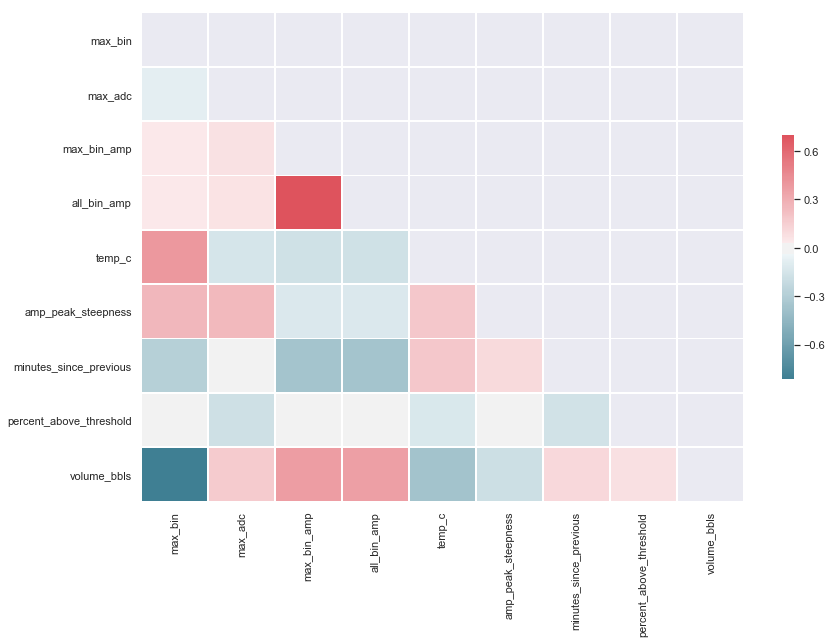

In [31]:
ds.check_correlations(fdata, features.get("numfeatures"), t=0.8, plot=True)

In [32]:
tsdata  = fdata
#tsdata.index = fdata[['datetime_ct']]
tsdata.index = data.datetime_ct

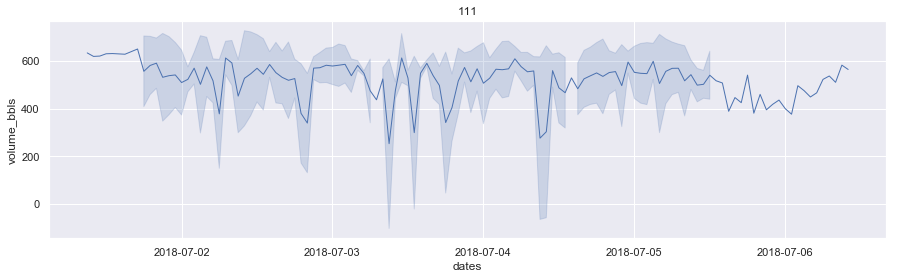

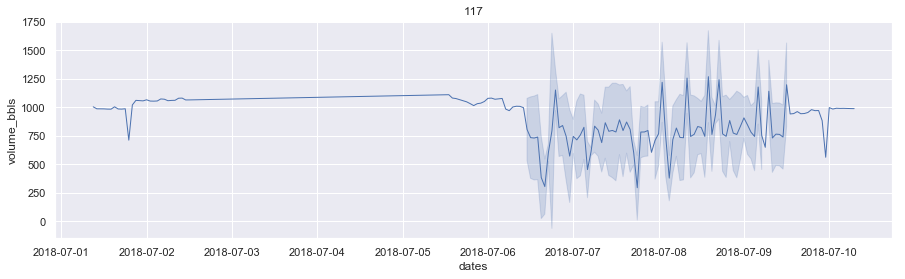

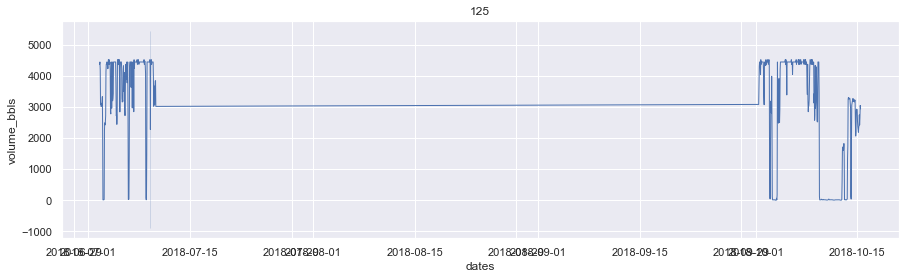

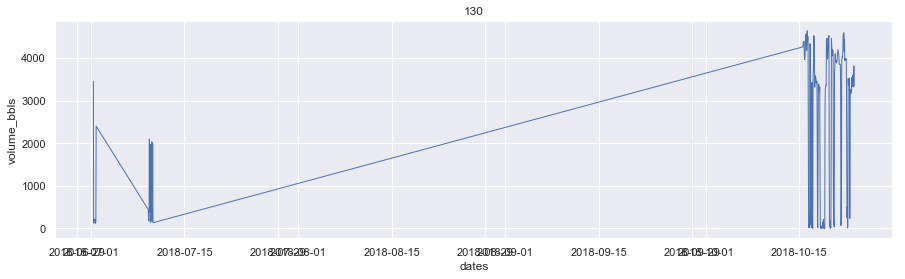

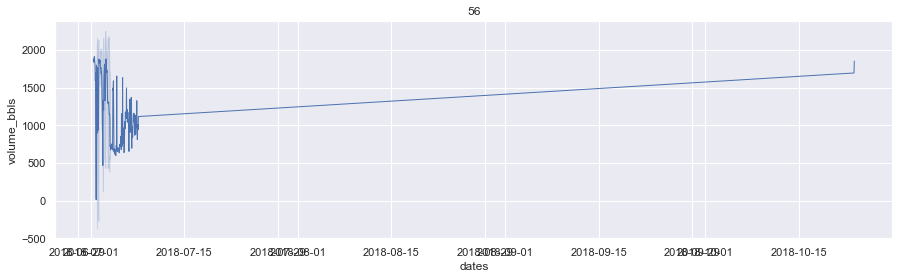

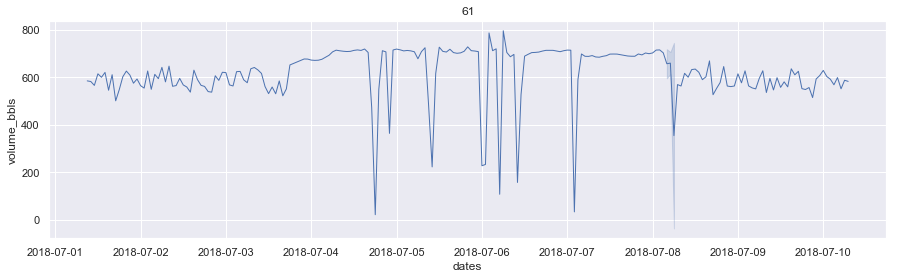

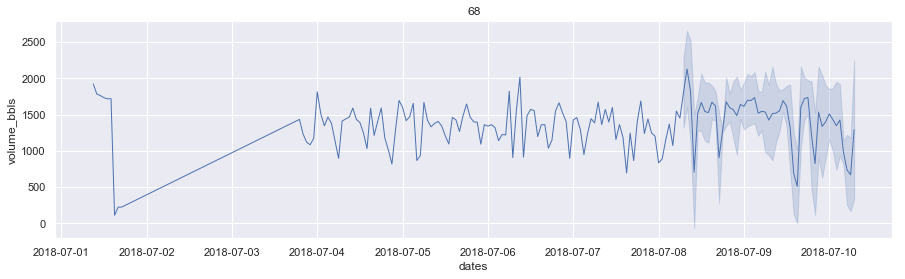

In [68]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm


temp = tsdata.reset_index()
temp["dates"] = data.datetime_ct

#sns.tsplot((data["volume_bbls"]), estimator=np.median, color="green", condition='pipe_id')
#sns.tsplot((fdata["volume_bbls"]), estimator=np.median)

for i in all_ids:
    plt.figure(figsize=(15,4))
    plt.title(i)
    sns.lineplot(data=temp[temp['pipe_id']==i], x="dates",
             estimator='mean',err_style='band',n_boot=200, ci="sd",
             palette="Set2", lw=1, y='volume_bbls',legend='full')


In [53]:
data.pipe_id.unique()

array([111, 117, 125, 130,  56,  61,  68])

In [54]:
tsdata.pipe_id.unique()

array([111, 117, 125, 130,  56,  61,  68])

In [55]:
tsdata.head()

,max_bin,max_adc,count_power_cycles,max_bin_amp,all_bin_amp,temp_c,amp_peak_steepness,minutes_since_previous,percent_above_threshold,percent_edge_excluded,pipe_id,volume_bbls
datetime_ct,,,,,,,,,,,,
2018-07-01 09:00:00,0.247799,0.846867,-1.736448,-0.274626,-0.269552,2.021247,0.273978,0.251212,-1.352482,-0.058821,111,634.25
2018-07-01 10:00:00,0.333797,0.929677,-2.256435,-0.274974,-0.269608,2.196797,0.221416,0.185058,-1.011395,-0.058821,111,619.59
2018-07-01 11:00:00,0.422484,0.917847,-1.216461,-0.274459,-0.269565,2.117001,0.463715,0.220340,-0.840851,-0.058821,111,621.02
2018-07-01 12:00:00,0.419796,0.941507,-1.736448,-0.275167,-0.269644,2.005288,0.229108,0.251212,-0.670308,-0.058821,111,630.65
2018-07-01 13:00:00,0.376797,0.976998,-1.216461,-0.275066,-0.269625,1.829738,0.219493,0.251212,-0.840851,-0.058821,111,631.56


In [56]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
coint_johansen(tsdata,-1,1).eig

array([0.28302774, 0.22127043, 0.15886349, 0.14978084, 0.12638043,
       0.09786019, 0.05548613, 0.0367898 , 0.03080832, 0.02772498,
       0.01337958, 0.00041084])

In [86]:
for i in all_ids:
    some = tsdata[features.get('numfeatures')][tsdata['pipe_id'] == i].describe().T["std"] > 0.00000000000001
    print(list(some[some].index))

['max_bin', 'max_adc', 'max_bin_amp', 'all_bin_amp', 'temp_c', 'amp_peak_steepness', 'minutes_since_previous', 'percent_above_threshold', 'volume_bbls']
['max_bin', 'max_adc', 'max_bin_amp', 'all_bin_amp', 'temp_c', 'amp_peak_steepness', 'minutes_since_previous', 'percent_above_threshold', 'volume_bbls']
['max_bin', 'max_adc', 'max_bin_amp', 'all_bin_amp', 'temp_c', 'amp_peak_steepness', 'minutes_since_previous', 'percent_above_threshold', 'volume_bbls']
['max_bin', 'max_adc', 'max_bin_amp', 'all_bin_amp', 'temp_c', 'amp_peak_steepness', 'minutes_since_previous', 'percent_above_threshold', 'volume_bbls']
['max_bin', 'max_adc', 'max_bin_amp', 'all_bin_amp', 'temp_c', 'amp_peak_steepness', 'minutes_since_previous', 'volume_bbls']
['max_bin', 'max_adc', 'max_bin_amp', 'all_bin_amp', 'temp_c', 'amp_peak_steepness', 'minutes_since_previous', 'volume_bbls']
['max_bin', 'max_adc', 'max_bin_amp', 'all_bin_amp', 'temp_c', 'amp_peak_steepness', 'minutes_since_previous', 'volume_bbls']


In [95]:
from statsmodels.tsa.vector_ar.var_model import VAR
pd.options.display.float_format = '{:.2f}'.format

res = []

cols =  ['max_bin', 'max_adc', 'count_power_cycles', 'max_bin_amp', 'all_bin_amp', 'temp_c', 'amp_peak_steepness', 'minutes_since_previous', 'volume_bbls']

for i in all_ids:
    some = tsdata[cols][tsdata['pipe_id'] == i].describe().T["std"] > 0.00001
    temp = tsdata[cols][tsdata['pipe_id'] == i]
    print("\npipe id", i, "dimensions")
    #print("\n", coint_johansen(temp,-1,1).eig)
    train = temp[:int(0.78*(len(temp)))]
    valid = temp[int(0.22*(len(temp))):]
    
    model = VAR(endog=train)
    model_fit = model.fit()
    
    prediction = model_fit.forecast(model_fit.y, steps=len(valid))
    pred = pd.DataFrame(index=range(0,len(prediction)),columns=cols)
    

    for j in range(0,9):
        for i in range(0, len(prediction)):
            pred.iloc[i][j] = prediction[i][j]

    #check rmse
    rmse = np.sqrt(mean_squared_error(pred['volume_bbls'], valid['volume_bbls']))
    res.append(rmse)
    print('rmse value for volume_bbls is : ', rmse)


pipe id 111 dimensions
rmse value for volume_bbls is :  116.00077530168738

pipe id 117 dimensions
rmse value for volume_bbls is :  273.6961130493849

pipe id 125 dimensions
rmse value for volume_bbls is :  2037.4655819224893

pipe id 130 dimensions
rmse value for volume_bbls is :  1785.1365251103261

pipe id 56 dimensions
rmse value for volume_bbls is :  459.0742009772885

pipe id 61 dimensions
rmse value for volume_bbls is :  111.15908331447234

pipe id 68 dimensions
rmse value for volume_bbls is :  316.6033514229201


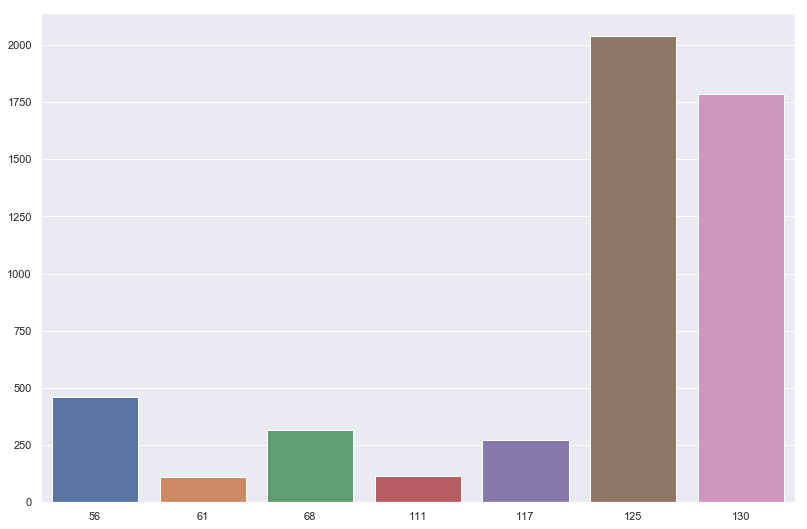

In [99]:
sns.barplot(y=res, x=all_ids)

In [101]:
np.mean(res)

728.4479472997955

In [97]:
#make final predictions

for i in all_ids:
    some = tsdata[cols][tsdata['pipe_id'] == i].describe().T["std"] > 0.00001
    temp = tsdata[cols][tsdata['pipe_id'] == i]
    
    model = VAR(endog=temp)
    model_fit = model.fit()
    yhat = pd.DataFrame(model_fit.forecast(model_fit.y, steps=6), columns=cols)
    print("\n forecast for pipe id", i , "\n\n", yhat['volume_bbls'])


 forecast for pipe id 111 

 0   544.48
1   563.11
2   560.88
3   547.80
4   538.33
5   532.66
Name: volume_bbls, dtype: float64

 forecast for pipe id 117 

 0   822.77
1   749.27
2   731.12
3   742.78
4   756.84
5   771.27
Name: volume_bbls, dtype: float64

 forecast for pipe id 125 

 0    -7.56
1   154.82
2   363.66
3   574.41
4   772.76
5   954.87
Name: volume_bbls, dtype: float64

 forecast for pipe id 130 

 0   2097.64
1   1974.32
2   1954.52
3   1995.80
4   2042.99
5   2101.37
Name: volume_bbls, dtype: float64

 forecast for pipe id 56 

 0    919.07
1    970.21
2   1012.70
3   1061.39
4   1096.47
5   1126.23
Name: volume_bbls, dtype: float64

 forecast for pipe id 61 

 0   597.30
1   598.85
2   604.86
3   607.82
4   609.63
5   611.04
Name: volume_bbls, dtype: float64

 forecast for pipe id 68 

 0    863.94
1    960.57
2   1053.50
3   1131.72
4   1194.60
5   1241.24
Name: volume_bbls, dtype: float64


references
* https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc451.htm
* https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/
* 